In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib notebook

# A-Z Handwritten Alphabets

Dataset from: https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format. It contains $m = 372450$ alphabet characters A-Z. We note that this contains uppercase and lowercase letters (unsure).

# Load the data

In [2]:
# Read the CSV file
filename = "C:/Users/tonba/OneDrive/Desktop/Machine Learning Projects/datasets/Character Classification Using CNN/A_Z Handwritten Data.csv"
data = pd.read_csv(filename)

# Convert to NumPy array
data = data.to_numpy()

# Shuffle the data
np.random.shuffle(data)

# Data overview

The zeroth column represents the target variable (A is character 0 and Z is character 25), and columns 1 to 785 are the pixel intensities.

##### Number of rows

In [3]:
len(data)

372450

##### Number of features

In [4]:
len(data[:,1:].T)

784

##### Frequency distribution of the characters

<IPython.core.display.Javascript object>


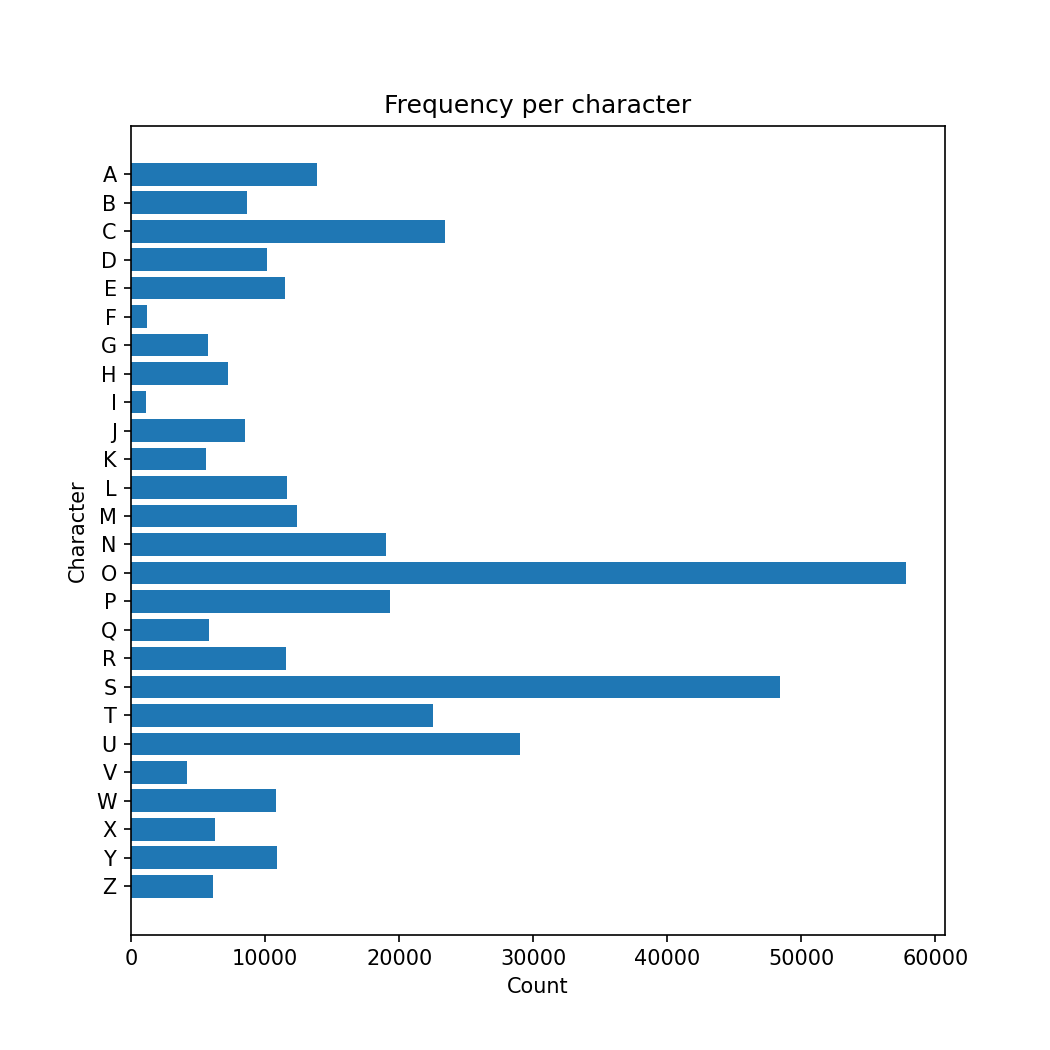

In [5]:
import string

letters = list(string.ascii_uppercase)
dictionary_characters = dict(zip(np.arange(0,26), letters))

counts = pd.DataFrame(data[:,0]).value_counts(sort=False).to_numpy()

plt.figure(figsize=(7,7))
plt.barh(letters[::-1], counts[::-1])
plt.xlabel('Count')
plt.ylabel('Character')
plt.title('Frequency per character')
plt.show()

The letter O has the most number of occurences, while the letter I has the fewest. The distribution of each letter is uneven. This might cause issues in the performance of the trained model later on.

##### Worst 5 letters in terms of count

In [6]:
print([(dictionary_characters[index], counts[index]) for index in np.argsort(counts)][:10])

[('I', 1120), ('F', 1163), ('V', 4182), ('K', 5603), ('G', 5762), ('Q', 5812), ('Z', 6076), ('X', 6272), ('H', 7218), ('J', 8493)]


The letters I, F, V, K, and G have very low counts.

##### Worst 5 letters in terms of count

In [7]:
print([(dictionary_characters[index], counts[index]) for index in np.argsort(counts)[::-1]][:10])

[('O', 57825), ('S', 48419), ('U', 29008), ('C', 23409), ('T', 22495), ('P', 19341), ('N', 19010), ('A', 13869), ('M', 12336), ('L', 11586)]


The letters O, S, U, C, and T have high counts.

##### Let's visualize some of the images

<IPython.core.display.Javascript object>


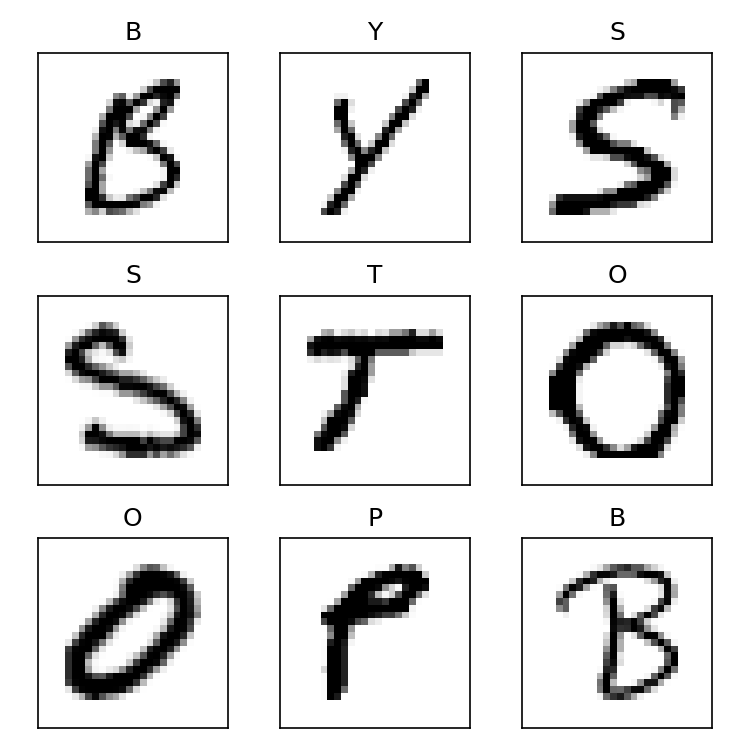

In [8]:
fig, ax = plt.subplots(3,3, figsize = (5,5))
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(data[i, 1:].reshape((28,28)), cmap='Greys')
    axes[i].set_title(dictionary_characters[data[i,0]])
    axes[i].tick_params(top=False,
                       bottom=False,
                       left=False,
                       right=False,
                       labelleft=False,
                       labelbottom=False)
    
plt.tight_layout()

# Pre-processing

When we process the data before feeding to TensorFlow we need to reshape from $(m=372450, n=785)$ to $(m=372450, n_H=28, n_W=28, n_C=1)$.

1. Apply PCA OR other dimensionality reduction technique. (not needed for now)
1. Normalize the data by dividing the features by 255
2. Reshape the features to (m, 28, 28, 1)
3. Split into train, test, and dev sets. We use a 90%-5%-5% split since our data is quite large. We first split the data into train and test splits, and then split the test split further into test and dev set.

##### Grab the features and the target variable and normalizing the features

In [9]:
# Grab the features and target
features = data[:, 1:] / 255
target = data[:, 0]

##### Split into train and test sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10, random_state=42)

##### Split the test set into test and dev sets

In [11]:
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

##### Reshape the train, test, and dev sets and convert to TensorFlow tensors

In [12]:
X_train = tf.convert_to_tensor(X_train.reshape((len(X_train), 28, 28, 1)))
X_test = tf.convert_to_tensor(X_test.reshape((len(X_test), 28, 28, 1)))
X_dev = tf.convert_to_tensor(X_dev.reshape((len(X_dev), 28, 28, 1)))

##### Convert the target variable into one-hot vectors

In [13]:
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_dev = tf.convert_to_tensor(y_dev)

##### Remove these variables to reserve memory

In [14]:
del [data, features, target, counts]

# CNN Model

To generalize our model further, we perform data augmentation first.

##### Data augmentation

In [15]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.3))
    data_augmentation.add(RandomTranslation((-0.3, 0.3),(-0.3, 0.3)))
    
    return data_augmentation

# This will be used in parallel with our final model
data_augmentation = data_augmenter() 

##### Construct the CNN Model using the Functional API

In [16]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D

def char_model(IMG_SIZE, data_augmentation):
    IMG_SIZE = IMG_SIZE + (1,)
    input_layer = Input(shape=IMG_SIZE)
    
    # Custom CNN
    #_______________________________________________
    
    # Apply data augmentation to the inputs
    X = data_augmentation(input_layer) 
    
    # 1st Convolutional layer
    X = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(X) # increase number of channels
    X = MaxPooling2D(pool_size=(2, 2), strides=1)(X) # subsample
    
    # 2nd Convolutional layer
    X = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(X) # increase number of channels
    X = MaxPooling2D(pool_size=(2, 2), strides=1)(X) # subsample
    
    # 3rd Convolutional layer
    X = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(X) # increase number of channels
    X = MaxPooling2D(pool_size=(2, 2), strides=1)(X) # subsample
    X = Dropout(0.3)(X)
    
    # Flatten the output of the convolutional layers
    X = Flatten()(X)
    X = Dense(120, activation='relu')(X)
    X = Dense(84, activation='relu')(X)
    
    outputs = Dense(26,activation='softmax')(X)
    
    #_______________________________________________
    
    model = tf.keras.Model(input_layer, outputs)
    
    return model

##### Compile and Train the model

In [17]:
# Model compilation
IMG_SIZE = (28,28)
model = char_model(IMG_SIZE, data_augmentation)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Recall that Adam is just momentum + RMSProp
              loss='sparse_categorical_crossentropy', # multi-class classification problem
              metrics=['accuracy'])
model.summary()

# Training
history = model.fit(x=X_train,y=y_train, batch_size=128 , validation_data=(X_dev, y_dev), epochs=20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                         

2619/2619 [==============================] - 250s 94ms/step - loss: 1.4420 - accuracy: 0.5631 - val_loss: 0.6991 - val_accuracy: 0.7616
Epoch 2/20
2619/2619 [==============================] - 243s 93ms/step - loss: 0.8638 - accuracy: 0.7297 - val_loss: 0.4462 - val_accuracy: 0.8624
Epoch 3/20
2619/2619 [==============================] - 239s 91ms/step - loss: 0.7472 - accuracy: 0.7643 - val_loss: 0.4828 - val_accuracy: 0.8501
Epoch 4/20
2619/2619 [==============================] - 241s 92ms/step - loss: 0.6812 - accuracy: 0.7859 - val_loss: 0.4377 - val_accuracy: 0.8674
Epoch 5/20
2619/2619 [==============================] - 237s 91ms/step - loss: 0.6410 - accuracy: 0.7991 - val_loss: 0.4645 - val_accuracy: 0.8575
Epoch 6/20
2619/2619 [==============================] - 237s 90ms/step - loss: 0.6083 - accuracy: 0.8083 - val_loss: 0.3962 - val_accuracy: 0.8772
Epoch 7/20
2619/2619 [==============================] - 237s 91ms/step - loss: 0.5827 - accuracy: 0.8164 - val_loss: 0.3848 - val

**Note**: Our model has 85% accuracy on the training set, but ~90% on the validation set. Since we only applied data augmentation to the training set, our validation and test scores are expected to be much higher because the validation and test sets do not posses the imperfections brought by data augmentation. This means that the model will perform worse in the real world.

# Make predictions

In [18]:
y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)
print(y_pred)

582/582 [==============================] - 4s 6ms/step
tf.Tensor([ 2 14 24 ...  4 18 18], shape=(18622,), dtype=int64)


# Model evaluation

##### Loss value for each epoch

<IPython.core.display.Javascript object>


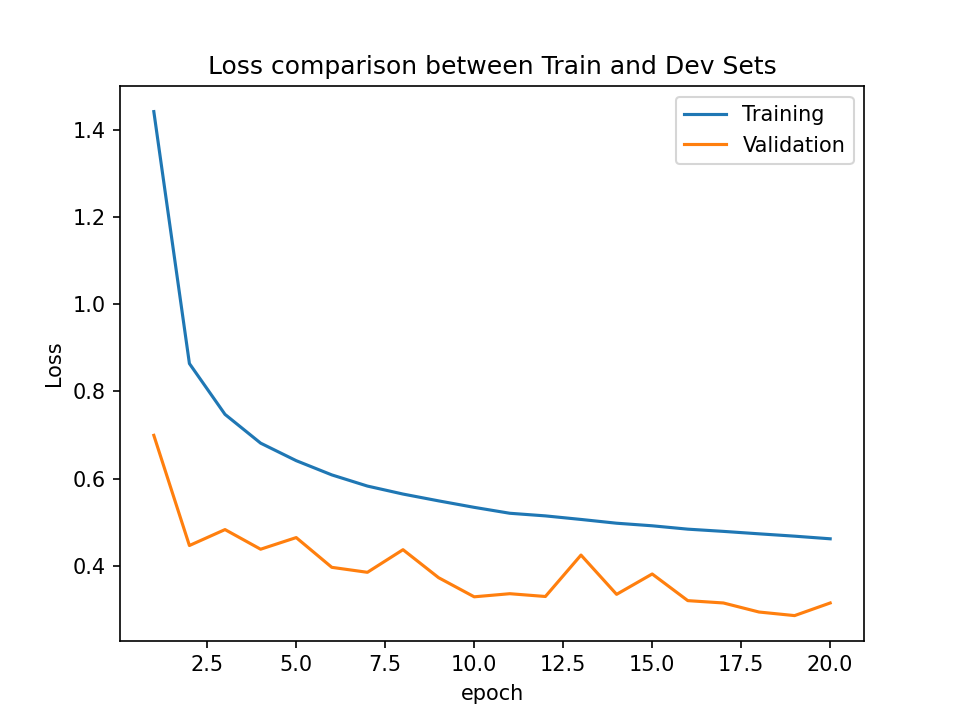

In [20]:
plt.figure()
plt.plot(np.arange(0,20) + 1, history.history['loss'], label='Training')
plt.plot(np.arange(0,20) + 1, history.history['val_loss'], label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss comparison between Train and Dev Sets')
plt.show()

Our model is underfitting (kinda).

##### Precision, Recall, and F1 Score per class

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# If we set average other than None, it simply takes the average of the precision scores for each class
precision_all = precision_score(y_test.numpy(), y_pred.numpy(), average=None) 
recall_all = recall_score(y_test.numpy(), y_pred.numpy(), average=None)
f1_all = f1_score(y_test.numpy(), y_pred.numpy(), average=None)


df_metrics = pd.DataFrame({'precision':precision_all,
                          'recall':recall_all,
                          'F1':f1_all})
df_metrics.index = list(dictionary_characters.values())
df_metrics

,precision,recall,F1
A,0.900925,0.947222,0.923494
B,0.737589,0.976526,0.840404
C,0.855980,0.887764,0.871582
D,0.846608,0.604211,0.705160
E,0.861244,0.916808,0.888158
F,1.000000,0.701493,0.824561
G,0.840278,0.880000,0.859680
H,0.837838,0.861111,0.849315
I,0.765957,0.642857,0.699029
J,0.876682,0.855580,0.866002


##### 5 letters with worst precision

Low `precision` here indicates that a letter has a lot of false positives. 

In [22]:
[(dictionary_characters[index], round(df_metrics.loc[dictionary_characters[index]]['precision'], 2)) for index in np.argsort(df_metrics['precision'].values)[:5]]

[('Z', 0.56), ('B', 0.74), ('I', 0.77), ('H', 0.84), ('Q', 0.84)]

##### 5 letters with worst recall

Low `recall` here indicates that a letter has a lot of false negatives. 

In [23]:
[(dictionary_characters[index], round(df_metrics.loc[dictionary_characters[index]]['recall'], 2)) for index in np.argsort(df_metrics['recall'].values)[:5]]

[('D', 0.6), ('I', 0.64), ('F', 0.7), ('V', 0.71), ('Z', 0.74)]

##### 5 letters with worst F1 score

In [24]:
[(dictionary_characters[index], round(df_metrics.loc[dictionary_characters[index]]['F1'], 2)) for index in np.argsort(df_metrics['F1'].values)[:5]]

[('Z', 0.64), ('I', 0.7), ('D', 0.71), ('V', 0.78), ('F', 0.82)]

Model needs more work on F, Z, J, I, and D.

# Save the model

In [25]:
model.save('model - A-Z_characters_recognition (Baseline).h5')